In [1]:
#!rm -rf x86_64
#!nrnivmodl mechanisms
%reset -f

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import bluepyopt as bpop
import bluepyopt.ephys as ephys

In [4]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

## Setup

In [5]:
morph = ephys.morphologies.NrnFileMorphology('morphology/WT-dMSN_P270-20_1.02_SGA1-m24.swc')

In [6]:
somatic_loc = ephys.locations.NrnSeclistLocation('somatic', seclist_name='somatic')
all_loc     = ephys.locations.NrnSeclistLocation('all',     seclist_name='all'    )
basal_loc   = ephys.locations.NrnSeclistLocation('basal',   seclist_name='basal'  )

In [7]:
nrn = ephys.simulators.NrnSimulator()

## Mechanisms

In [8]:
mechanisms = []
channels = ['naf', 'kaf', 'kas', 'kir']
for chan in channels:
    mechanisms.append( ephys.mechanisms.NrnMODMechanism(
        name='%s.somatic' % (chan),
        mod_path=None,
        prefix=chan,
        locations=[somatic_loc],
        preloaded=True)
    )
mechanisms.append( ephys.mechanisms.NrnMODMechanism(
        name='pas.all',
        mod_path=None,
        prefix='pas',
        preloaded=True,
        locations=[all_loc])
)
mechanisms.append( ephys.mechanisms.NrnMODMechanism(
        name='kaf.basal',
        mod_path=None,
        preloaded=True,
        prefix='kaf',
        locations=[basal_loc])
)

## Parameters
### Passive

In [9]:
parameters = []
parameters.append( ephys.parameters.NrnSectionParameter(
        name='cm',
        param_name='cm',
        value=1.0,
        locations=[all_loc],
        frozen=True)
     )
parameters.append( ephys.parameters.NrnSectionParameter(                                    
            name='g_pas',
            param_name='g_pas',
            locations=[all_loc],
            value=1.25e-5,
            bounds=None,
            frozen=True) 
)
parameters.append( ephys.parameters.NrnSectionParameter(                                    
            name='e_pas',
            param_name='e_pas',
            locations=[all_loc],
            value=-70,
            frozen=True) 
)

### Active

In [10]:
for chan in channels:
    parameters.append( ephys.parameters.NrnRangeParameter(                                    
            name='gbar_%s' % (chan),
            param_name='gbar_%s' % (chan),
            locations=[somatic_loc],
            bounds=[0.0001, 20.0],
            frozen=False) 
        )
'''
scaler = ephys.parameterscalers.NrnSegmentSomaDistanceScaler(
        distribution="({v1} + {v2}/(1+math.exp(({distance}-{v3})/{v4}) ))*{value}",
        dist_param_names=['v1', 'v2', 'v3', 'v4']
        )
'''
from distance_scaler import *

dist_param_names  = ['v1', 'v2', 'v3', 'v4']
dist_param_values = [1.0, 0.810298, 40.239029, -49.078082]
dist_param_bounds = [[0.99,1.01], [0.8,0.9], [35.0,45.0], [-55.0,-45]]

scaler_dict = {}

scaler = NrnSegmentSomaDistanceScaler(
        distribution="({v1} + {v2}/(1+math.exp(({distance}-{v3})/{v4}) ))*{value}",
        dist_param_names=dist_param_names
        )

for n,name in enumerate(dist_param_names):
    vx = ephys.parameters.NrnSectionParameter(
        name=name,
        param_name=name,
        locations=[],
        frozen=False,
        bounds=dist_param_bounds[n]
        )
    
    parameters.append( vx )
    
    # def parameter in scaler
    setattr(scaler, name, vx)
    
    # enable optimization by storing names in dict
    scaler_dict[name] = dist_param_values[n]

parameters.append( ephys.parameters.NrnRangeParameter(                                    
        name='gbar_kaf.basal',
        param_name='gbar_kaf',
        value_scaler=scaler,
        locations=[basal_loc],
        bounds=[0.0001, 20.0],
        frozen=False) 
    )



In [11]:
simple_cell = ephys.models.CellModel(
        name='simple_cell',
        morph=morph,
        mechs=mechanisms,
        params=parameters)


In [523]:
#print(simple_cell)
default_params = {    'gbar_naf': 15.0, 
                      'gbar_kaf': 0.8, 
                      'gbar_kaf.basal': 0.4,
                      'gbar_kas': 0.05, 
                      'gbar_kir': 0.10}

for key in scaler_dict:
    default_params[key] = scaler_dict[key]

simple_cell.freeze(default_params)
    
    simple_cell.instantiate(sim=nrn)

    cell = simple_cell.icell

    for sec in cell.allsec():

        cell_index, comp = sec.name().split('[')[1].split(']')
        if comp.find('soma') > 0:
            nrn.neuron.h.distance(0, 0.5, sec=sec)

        if cell_index == '0':
            print sec.name()
            print '\tL : %f' % sec.L
            print '\tnseg : %d' % sec.nseg
            for seg in sec:
                distance = nrn.neuron.h.distance(1, seg.x, sec=sec)
                print '\tx : %f;\tarea : %f' % (seg.x, seg.area())
                print '\t\t\tdiam : %f' % seg.diam
                print '\t\t\tdist : %f' % distance


simple_cell[0].soma[0]
	L : 12.200000
	nseg : 1
	x : 0.500000;	area : 467.594636
			diam : 12.200000
			dist : 0.000000
simple_cell[0].axon[0]
	L : 60.000000
	nseg : 3
	x : 0.166667;	area : 62.831853
			diam : 1.000000
			dist : 10.000000
	x : 0.500000;	area : 62.831853
			diam : 1.000000
			dist : 30.000000
	x : 0.833333;	area : 62.831853
			diam : 1.000000
			dist : 50.000000
simple_cell[0].dend[0]
	L : 4.498863
	nseg : 1
	x : 0.500000;	area : 33.276324
			diam : 2.354413
			dist : 2.249431
simple_cell[0].dend[1]
	L : 44.293783
	nseg : 3
	x : 0.166667;	area : 77.400071
			diam : 1.666964
			dist : 11.881160
	x : 0.500000;	area : 63.357987
			diam : 1.365935
			dist : 26.645754
	x : 0.833333;	area : 62.673181
			diam : 1.351171
			dist : 41.410349
simple_cell[0].dend[2]
	L : 28.229803
	nseg : 1
	x : 0.500000;	area : 106.422515
			diam : 1.199965
			dist : 62.907547
simple_cell[0].dend[3]
	L : 148.212005
	nseg : 7
	x : 0.071429;	area : 68.060539
			diam : 1.023164
			dist : 87.609020
	

In [12]:
soma_loc = ephys.locations.NrnSeclistCompLocation(
        name='soma',
        seclist_name='somatic',
        sec_index=0,
        comp_x=0.5)

In [13]:
sweep_protocols = []
for protocol_name, amplitude in [('step1', 350e-3), ('step2', 400e-3)]:
    stim = ephys.stimuli.NrnSquarePulse(
                step_amplitude=amplitude,
                step_delay=100,
                step_duration=350,
                location=soma_loc,
                total_duration=500)
    rec = ephys.recordings.CompRecording(
            name='%s.soma.v' % protocol_name,
            location=soma_loc,
            variable='v')
    protocol = ephys.protocols.SweepProtocol(protocol_name, [stim], [rec])
    sweep_protocols.append(protocol)
twostep_protocol = ephys.protocols.SequenceProtocol('twostep', protocols=sweep_protocols)

In [14]:

default_params = {'gbar_naf': 15.0, 
                  'gbar_kaf': 0.8, 
                  'gbar_kaf.basal': 0.4,
                  'gbar_kas': 0.05, 
                  'gbar_kir': 0.10}
for key in scaler_dict:
    default_params[key] = scaler_dict[key]
responses = twostep_protocol.run(cell_model=simple_cell, param_values=default_params, sim=nrn)

default_params = {'gbar_naf': 15.0, 
                  'gbar_kaf': 0.8, 
                  'gbar_kaf.basal': 0.4,
                  'gbar_kas': 0.05, 
                  'gbar_kir': 0.10}
for key in scaler_dict:
    default_params[key] = scaler_dict[key]
responses2 = twostep_protocol.run(cell_model=simple_cell, param_values=default_params, sim=nrn)

No handlers could be found for logger "bluepyopt.ephys.morphologies"


{'distance': '2.2494314335622549', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '11.88115999783783', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '26.645754259264471', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '41.410348520691109', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '62.90754715377652', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '87.609020456579927', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '108.78216405744253', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distan

{'distance': '149.41407184911714', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '68.269979601333574', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '87.695949684794627', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '107.12191976825567', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '126.54788985171672', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '145.97385993517776', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '165.3998300186388', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'dista

{'distance': '208.62063998029456', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '122.15277959774451', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '11.972228776055752', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '35.916686328167259', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '59.861143880278767', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '19.810258828442784', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '50.876878734762968', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'dist

{'distance': '98.813861078738071', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '116.1735769356109', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '135.44670682500063', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '154.7198367143904', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '116.26823868544793', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '135.73069207451169', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '155.19314546357549', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distan

No handlers could be found for logger "bluepyopt.ephys.morphologies"


{'distance': '2.2494314335622549', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '11.88115999783783', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '26.645754259264471', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '41.410348520691109', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '62.90754715377652', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '87.609020456579927', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '108.78216405744253', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distan

{'distance': '149.41407184911714', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '68.269979601333574', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '87.695949684794627', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '107.12191976825567', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '126.54788985171672', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '145.97385993517776', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '165.3998300186388', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'dista

{'distance': '208.62063998029456', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '122.15277959774451', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '11.972228776055752', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '35.916686328167259', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '59.861143880278767', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '19.810258828442784', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '50.876878734762968', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'dist

{'distance': '98.813861078738071', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '116.1735769356109', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '135.44670682500063', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '154.7198367143904', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '116.26823868544793', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '135.73069207451169', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '155.19314546357549', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distan

No handlers could be found for logger "bluepyopt.ephys.morphologies"


{'distance': '2.2494314335622549', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '11.88115999783783', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '26.645754259264471', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '41.410348520691109', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '62.90754715377652', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '87.609020456579927', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '108.78216405744253', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distan

{'distance': '149.41407184911714', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '68.269979601333574', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '87.695949684794627', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '107.12191976825567', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '126.54788985171672', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '145.97385993517776', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '165.3998300186388', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'dista

v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '122.15277959774451', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '11.972228776055752', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '35.916686328167259', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '59.861143880278767', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '19.810258828442784', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '50.876878734762968', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'dista

{'distance': '98.813861078738071', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '116.1735769356109', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '135.44670682500063', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '154.7198367143904', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '116.26823868544793', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '135.73069207451169', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '155.19314546357549', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distan

No handlers could be found for logger "bluepyopt.ephys.morphologies"


{'distance': '2.2494314335622549', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '11.88115999783783', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '26.645754259264471', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '41.410348520691109', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '62.90754715377652', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '87.609020456579927', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '108.78216405744253', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distan

{'distance': '149.41407184911714', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '68.269979601333574', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '87.695949684794627', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '107.12191976825567', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '126.54788985171672', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '145.97385993517776', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '165.3998300186388', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'dista

{'distance': '208.62063998029456', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '122.15277959774451', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '11.972228776055752', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '35.916686328167259', 'value': '0.40000000000000002'}
v1
v2
v4
v3
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '59.861143880278767', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '19.810258828442784', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '50.876878734762968', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'dist

{'distance': '98.813861078738071', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '116.1735769356109', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '135.44670682500063', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '154.7198367143904', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '116.26823868544793', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '135.73069207451169', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '155.19314546357549', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distan

No handlers could be found for logger "bluepyopt.ephys.morphologies"


{'distance': '2.2494314335622549', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '11.88115999783783', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '26.645754259264471', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '41.410348520691109', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '62.90754715377652', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '87.609020456579927', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '108.78216405744253', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distan

{'distance': '149.41407184911714', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '68.269979601333574', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '87.695949684794627', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '107.12191976825567', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '126.54788985171672', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '145.97385993517776', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '165.3998300186388', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'dista

{'distance': '208.62063998029456', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '122.15277959774451', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '11.972228776055752', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '35.916686328167259', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '59.861143880278767', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '19.810258828442784', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '50.876878734762968', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'dist

{'distance': '98.813861078738071', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '116.1735769356109', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '135.44670682500063', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '154.7198367143904', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '116.26823868544793', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '135.73069207451169', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '155.19314546357549', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distan

No handlers could be found for logger "bluepyopt.ephys.morphologies"


{'distance': '2.2494314335622549', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '11.88115999783783', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '26.645754259264471', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '41.410348520691109', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '62.90754715377652', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '87.609020456579927', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '108.78216405744253', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distan

{'distance': '149.41407184911714', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '68.269979601333574', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '87.695949684794627', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '107.12191976825567', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '126.54788985171672', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '145.97385993517776', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '165.3998300186388', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'dista

{'distance': '208.62063998029456', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '122.15277959774451', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '11.972228776055752', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '35.916686328167259', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '59.861143880278767', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '19.810258828442784', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '50.876878734762968', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'dist

{'distance': '98.813861078738071', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '116.1735769356109', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '135.44670682500063', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '154.7198367143904', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '116.26823868544793', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '135.73069207451169', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '155.19314546357549', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distan

No handlers could be found for logger "bluepyopt.ephys.morphologies"


{'distance': '2.2494314335622549', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '11.88115999783783', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '26.645754259264471', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '41.410348520691109', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '62.90754715377652', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '87.609020456579927', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '108.78216405744253', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distan

{'distance': '149.41407184911714', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '68.269979601333574', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '87.695949684794627', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '107.12191976825567', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '126.54788985171672', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '145.97385993517776', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '165.3998300186388', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'dista

{'distance': '208.62063998029456', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '122.15277959774451', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '11.972228776055752', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '35.916686328167259', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '59.861143880278767', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '19.810258828442784', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '50.876878734762968', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'dist

{'distance': '98.813861078738071', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '116.1735769356109', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '135.44670682500063', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '154.7198367143904', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '116.26823868544793', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '135.73069207451169', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '155.19314546357549', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distan

No handlers could be found for logger "bluepyopt.ephys.morphologies"


{'distance': '2.2494314335622549', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '11.88115999783783', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '26.645754259264471', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '41.410348520691109', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '62.90754715377652', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '87.609020456579927', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '108.78216405744253', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distan

{'distance': '149.41407184911714', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '68.269979601333574', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '87.695949684794627', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '107.12191976825567', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '126.54788985171672', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '145.97385993517776', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '165.3998300186388', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'dista

{'distance': '208.62063998029456', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '122.15277959774451', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '11.972228776055752', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '35.916686328167259', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '59.861143880278767', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '19.810258828442784', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '50.876878734762968', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'dist

{'distance': '98.813861078738071', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '116.1735769356109', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '135.44670682500063', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '154.7198367143904', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '116.26823868544793', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '135.73069207451169', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distance': '155.19314546357549', 'value': '0.40000000000000002'}
v1
v2
v3
v4
{'v1': 1.0, 'v2': 0.810298, 'v3': 40.239029, 'v4': -49.078082}
{'distan

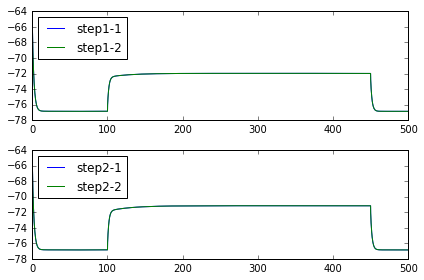

In [15]:

def plot_responses(responses):
    plt.subplot(2,1,1)
    plt.plot(responses['step1.soma.v']['time'], responses['step1.soma.v']['voltage'], label='step1-1')
    plt.plot(responses2['step1.soma.v']['time'], responses2['step1.soma.v']['voltage'], label='step1-2')
    plt.legend(loc=2)
    plt.subplot(2,1,2)
    plt.plot(responses['step2.soma.v']['time'], responses['step2.soma.v']['voltage'], label='step2-1')
    plt.plot(responses2['step2.soma.v']['time'], responses2['step2.soma.v']['voltage'], label='step2-2')
    plt.legend(loc=2)
    plt.tight_layout()

plot_responses(responses)

## Otimize

In [ ]:
efel_feature_means = {'step1': {'Spikecount': 1}, 'step2': {'Spikecount': 5}}

objectives = []

for protocol in sweep_protocols:
    stim_start = protocol.stimuli[0].step_delay
    stim_end = stim_start + protocol.stimuli[0].step_duration
    for efel_feature_name, mean in efel_feature_means[protocol.name].items():
        feature_name = '%s.%s' % (protocol.name, efel_feature_name)
        feature = ephys.efeatures.eFELFeature(
                    feature_name,
                    efel_feature_name=efel_feature_name,
                    recording_names={'': '%s.soma.v' % protocol.name},
                    stim_start=stim_start,
                    stim_end=stim_end,
                    exp_mean=mean,
                    exp_std=0.05 * mean)
        objective = ephys.objectives.SingletonObjective(
            feature_name,
            feature)
        objectives.append(objective)

In [ ]:
score_calc = ephys.objectivescalculators.ObjectivesCalculator(objectives)

In [ ]:
cell_evaluator = ephys.evaluators.CellEvaluator(
        cell_model=simple_cell,
        param_names=default_params.keys(),
        fitness_protocols={twostep_protocol.name: twostep_protocol},
        fitness_calculator=score_calc,
        sim=nrn)

In [ ]:
print(cell_evaluator.evaluate_with_dicts(default_params))

In [ ]:
optimisation = bpop.optimisations.DEAPOptimisation(
        evaluator=cell_evaluator,
        offspring_size = 8)

In [ ]:
final_pop, hall_of_fame, logs, hist = optimisation.run(max_ngen=5)

In [ ]:
for pop in final_pop:
    print pop

In [ ]:
for fame in hall_of_fame:
    print fame

In [ ]:
best_ind_dict = cell_evaluator.param_dict(hall_of_fame[0])
print(cell_evaluator.evaluate_with_dicts(best_ind_dict))

In [ ]:
resp_best = twostep_protocol.run(cell_model=simple_cell, param_values=best_ind_dict, sim=nrn)

In [ ]:
plt.subplot(2,1,1)
plt.plot(resp_best['step1.soma.v']['time'], resp_best['step1.soma.v']['voltage'], label='step1-1')
plt.legend(loc=2)
plt.subplot(2,1,2)
plt.plot(resp_best['step2.soma.v']['time'], resp_best['step2.soma.v']['voltage'], label='step2-1')
plt.legend(loc=2)
plt.tight_layout()
plt.show()

In [ ]:
import numpy
gen_numbers = logs.select('gen')
min_fitness = logs.select('min')
max_fitness = logs.select('max')
plt.plot(gen_numbers, min_fitness, label='min fitness')
plt.xlabel('generation #')
plt.ylabel('score (# std)')
plt.legend()
plt.xlim(min(gen_numbers) - 1, max(gen_numbers) + 1) 
plt.ylim(0.9*min(min_fitness), 1.1 * max(min_fitness))